In [ ]:
 from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Import dataset
df = pd.read_csv('/content/drive/MyDrive/Marketing Analytics/hotel_bookings.csv')
# Preview dataset
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


In [ ]:
# Data Prepration

# Specify the abbreviation
df.rename(columns={'adr':'average_daily_rate'}, inplace=True)

# Fix Null variable
df['children'].fillna(0, inplace=True)
df['babies'].fillna(0, inplace=True)
df.dropna(subset = ['country'], axis = 0, inplace= True)

# New column: region
# Based on country
europe = ['PRT','ESP','FRA','GBR','DEU','ITA','NLD','BEL','IRL','SWE','NOR','POL','CHE','AUT','ROU','GRC','CZE','HUN','DNK','FIN','SVN','SVK']
asia = ['CHN','IND','JPN','KOR','THA','VNM','SGP','MYS','IDN','PHL','PAK','LKA','ARE','QAT','SAU','OMN','ISR']
americas = ['USA','CAN','BRA','ARG','MEX','CHL','COL','PER','URY']
africa = ['ZAF','EGY','MAR','TUN','NGA','KEN','GHA','ETH']
oceania = ['AUS','NZL','FJI']
other = []

df['region'] = np.select([df['country'].isin(europe), df['country'].isin(asia), df['country'].isin(americas),
        df['country'].isin(africa), df['country'].isin(oceania)],
        ['Europe','Asia','Americas','Africa','Oceania'], default='Other')

# New column: total_guests
# From: adults, children, and babies
df['total_guests'] = df['adults'] + df['children'] + df['babies']

# New column: length_of_stay
# From: stays_in_weekend_nights and stays_in_week_nights
df['length_of_stay'] = df['stays_in_weekend_nights'] + df['stays_in_week_nights']

# New column: arrival_date
# From: arrival_date_year, arrival_date_month, and arrival_day_of_month
df['arrival_date'] = pd.to_datetime(
    df['arrival_date_year'].astype(str) + ' ' +
    df['arrival_date_month'] + ' ' +
    df['arrival_date_day_of_month'].astype(str),
    format='%Y %B %d'
)

# New column: season
# From: month
df['month'] = df['arrival_date'].dt.month

conditions = [df['month'].isin([12,1,2]),
              df['month'].isin([3,4,5]),
              df['month'].isin([6,7,8]),
              df['month'].isin([9,10,11])]

choices = ['Winter','Spring', 'Summer','Fall']
df['season'] = np.select(conditions, choices, default='Other')

# Remove invalid numbers
df = df[df['average_daily_rate'] > 0]
df = df[df['total_guests'] > 0]
df = df[df['length_of_stay'] > 0]
df = df[df['average_daily_rate'] <= df['average_daily_rate'].quantile(0.995)]

# Drop unnecessary columns
df.drop(['agent', 'company'], axis=1, inplace=True)
df.drop(['required_car_parking_spaces','total_of_special_requests','reservation_status', 'reservation_status_date','days_in_waiting_list','assigned_room_type'],
        axis = 1, inplace = True)
df.drop(['market_segment', 'previous_bookings_not_canceled'], axis =1, inplace = True)
df.drop(['previous_cancellations'], axis = 1, inplace = True)
df.drop(['adults', 'children', 'babies'], axis=1, inplace=True)
df.drop(['country'], axis=1, inplace=True)
df.drop(['stays_in_weekend_nights', 'stays_in_week_nights'], axis=1, inplace=True)
df.drop(['arrival_date_year', 'arrival_date_month', 'arrival_date_day_of_month'], axis=1, inplace=True)

# Preview dataset
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 116347 entries, 2 to 119389
Data columns (total 18 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   hotel                     116347 non-null  object        
 1   is_canceled               116347 non-null  int64         
 2   lead_time                 116347 non-null  int64         
 3   arrival_date_week_number  116347 non-null  int64         
 4   meal                      116347 non-null  object        
 5   distribution_channel      116347 non-null  object        
 6   is_repeated_guest         116347 non-null  int64         
 7   reserved_room_type        116347 non-null  object        
 8   booking_changes           116347 non-null  int64         
 9   deposit_type              116347 non-null  object        
 10  customer_type             116347 non-null  object        
 11  average_daily_rate        116347 non-null  float64       
 12  region 

,hotel,is_canceled,lead_time,arrival_date_week_number,meal,distribution_channel,is_repeated_guest,reserved_room_type,booking_changes,deposit_type,customer_type,average_daily_rate,region,total_guests,length_of_stay,arrival_date,month,season
2,Resort Hotel,0,7,27,BB,Direct,0,A,0,No Deposit,Transient,75.0,Europe,1.0,1,2015-07-01,7,Summer
3,Resort Hotel,0,13,27,BB,Corporate,0,A,0,No Deposit,Transient,75.0,Europe,1.0,1,2015-07-01,7,Summer
4,Resort Hotel,0,14,27,BB,TA/TO,0,A,0,No Deposit,Transient,98.0,Europe,2.0,2,2015-07-01,7,Summer
5,Resort Hotel,0,14,27,BB,TA/TO,0,A,0,No Deposit,Transient,98.0,Europe,2.0,2,2015-07-01,7,Summer
6,Resort Hotel,0,0,27,BB,Direct,0,C,0,No Deposit,Transient,107.0,Europe,2.0,2,2015-07-01,7,Summer


# K-Means Clustering to Understand Customer Segmentation


In [ ]:
# Create dummy variables
season_dummies = pd.get_dummies(df['season'], prefix = "season")
region_dummies = pd.get_dummies(df['region'], prefix = "region")

# Combine numerical features with dummy columns
data= pd.concat([df[['lead_time', 'length_of_stay', 'total_guests', 'average_daily_rate']], season_dummies, region_dummies], axis=1)

In [ ]:
for col in data.select_dtypes(include='bool').columns:
    data[col] = data[col].astype(int)  # Convert only the specific column, not the entire DataFrame
data.head()

,lead_time,length_of_stay,total_guests,average_daily_rate,season_Fall,season_Spring,season_Summer,season_Winter,region_Africa,region_Americas,region_Asia,region_Europe,region_Oceania,region_Other
2,7,1,1.0,75.0,0,0,1,0,0,0,0,1,0,0
3,13,1,1.0,75.0,0,0,1,0,0,0,0,1,0,0
4,14,2,2.0,98.0,0,0,1,0,0,0,0,1,0,0
5,14,2,2.0,98.0,0,0,1,0,0,0,0,1,0,0
6,0,2,2.0,107.0,0,0,1,0,0,0,0,1,0,0


In [ ]:
#How many people from this data set booked in each region
print(data['region_Europe'].sum())
print(data['region_Africa'].sum())
print(data['region_Asia'].sum())
print(data['region_Americas'].sum())

103,740/116,347

103740
442
2498
4762


(103, 6, 347)

In [ ]:
data.dropna(inplace=True)

# Standardize features
scaler = StandardScaler()

# Separate numerical and categorical columns
num_col = ['lead_time', 'length_of_stay', 'total_guests', 'average_daily_rate']
cat_col = ['season_Fall', 'season_Spring', 'season_Summer', 'season_Winter', 'region_Africa', 'region_Americas', 'region_Asia', 'region_Europe', 'region_Oceania', 'region_Other']

# Scale numerical columns
num_scaled = scaler.fit_transform(data[num_col])

# Concatenate scaled numerical and categorical dummy variables
x_prep = np.concatenate([num_scaled, data[cat_col].values], axis=1)

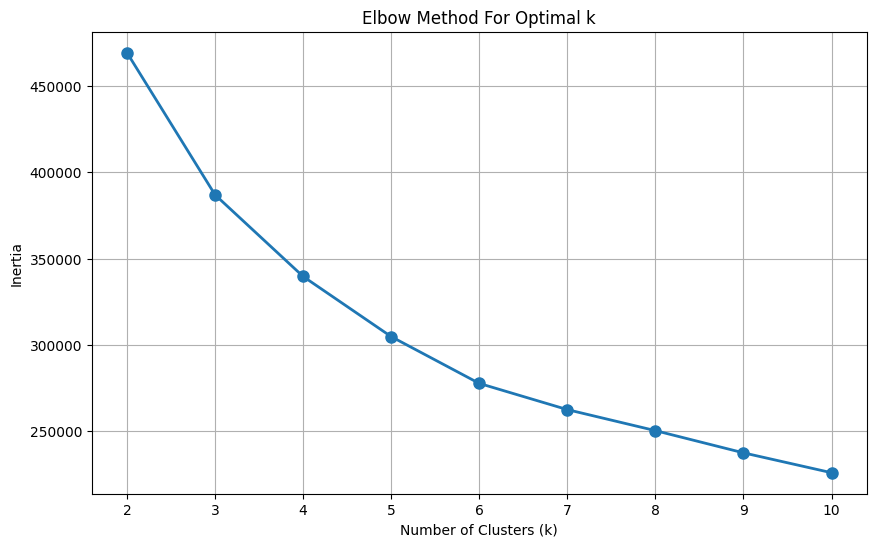

In [ ]:


# Calculate inertias (Elbow Method)
inertia = []
K_range = range(2,11)

for k in K_range:
  kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
  kmeans.fit(x_prep)
  inertia.append(kmeans.inertia_)

# Visualize Elbow Curve
plt.figure(figsize=(10, 6))
plt.plot(K_range, inertia, marker='o', linestyle='-', linewidth=2, markersize=8)
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.grid(True)
plt.xticks(K_range)
plt.show()

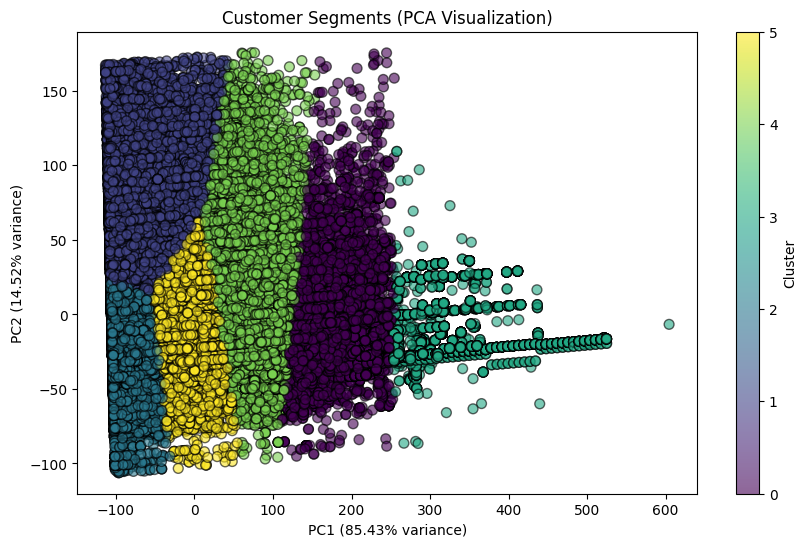

In [ ]:
# Apply KMeans clustering
kmeans = KMeans(n_clusters=6, random_state=42, n_init=10)
clusters = kmeans.fit_predict(data)

# Apply principle component analysis
pca = PCA(n_components=2)
X_pca = pca.fit_transform(data)

# Visualize clusters
plt.figure(figsize=(10, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis', s=50, alpha=0.6, edgecolors='k')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
plt.title('Customer Segments (PCA Visualization)')
plt.colorbar(label='Cluster')
plt.show()

In [ ]:

df_seg = pd.concat([
    df.loc[data.index].copy(),
    season_dummies.loc[data.index],
    region_dummies.loc[data.index]
], axis=1)

df_seg['Cluster'] = clusters


cluster_vars = [
    'lead_time',
    'length_of_stay',
    'total_guests',
    'average_daily_rate',
    'season_Fall', 'season_Spring', 'season_Summer', 'season_Winter',
    'region_Africa', 'region_Americas', 'region_Asia', 'region_Europe',
    'region_Oceania', 'region_Other'
]


cluster_summary_original = df_seg.groupby('Cluster')[cluster_vars].mean()
cluster_summary_original

,lead_time,length_of_stay,total_guests,average_daily_rate,season_Fall,season_Spring,season_Summer,season_Winter,region_Africa,region_Americas,region_Asia,region_Europe,region_Oceania,region_Other
Cluster,,,,,,,,,,,,,,
0,285.183382,3.999592,1.984589,87.001690,0.368314,0.190068,0.395956,0.045662,0.000815,0.022016,0.003425,0.945939,0.003506,0.024299
1,36.910795,3.256850,2.322930,168.414224,0.197363,0.245725,0.504223,0.052689,0.007983,0.066028,0.037340,0.828286,0.006232,0.054131
2,19.193008,2.793019,1.743309,77.938253,0.257309,0.264537,0.129917,0.348237,0.004756,0.040789,0.023888,0.889134,0.003090,0.038344
3,431.676997,2.639181,1.908729,78.360279,0.404038,0.163776,0.347171,0.085016,0.000284,0.004265,0.000284,0.967870,0.014501,0.012795
4,177.788354,4.330769,2.083170,112.754702,0.169105,0.266455,0.514859,0.049580,0.002011,0.036003,0.011113,0.907025,0.003419,0.040428
5,95.565019,3.758431,1.936915,90.894091,0.209881,0.383790,0.229509,0.176820,0.002454,0.039963,0.025783,0.895122,0.004242,0.032436


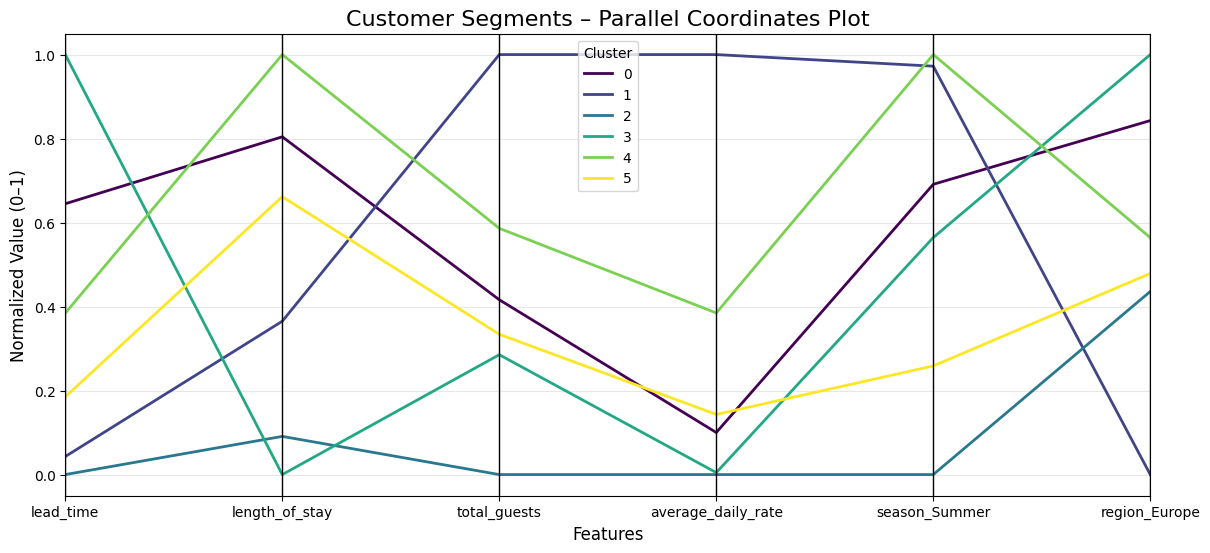

In [ ]:
from pandas.plotting import parallel_coordinates


parallel_vars = [
'lead_time',
'length_of_stay',
'total_guests',
'average_daily_rate',
'season_Summer',
'region_Europe'
]

df_parallel = cluster_summary_original[parallel_vars].copy()
df_parallel['Cluster'] = cluster_summary_original.index


df_parallel_norm = df_parallel.copy()
for col in parallel_vars:
  col_min = df_parallel[col].min()
  col_max = df_parallel[col].max()
  df_parallel_norm[col] = (df_parallel[col] - col_min) / (col_max - col_min + 1e-9)


plt.figure(figsize=(14, 6))
parallel_coordinates(df_parallel_norm, class_column='Cluster', colormap='viridis', linewidth=2)

plt.title("Customer Segments – Parallel Coordinates Plot", fontsize=16)
plt.xlabel("Features", fontsize=12)
plt.ylabel("Normalized Value (0–1)", fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend(title="Cluster")
plt.show()

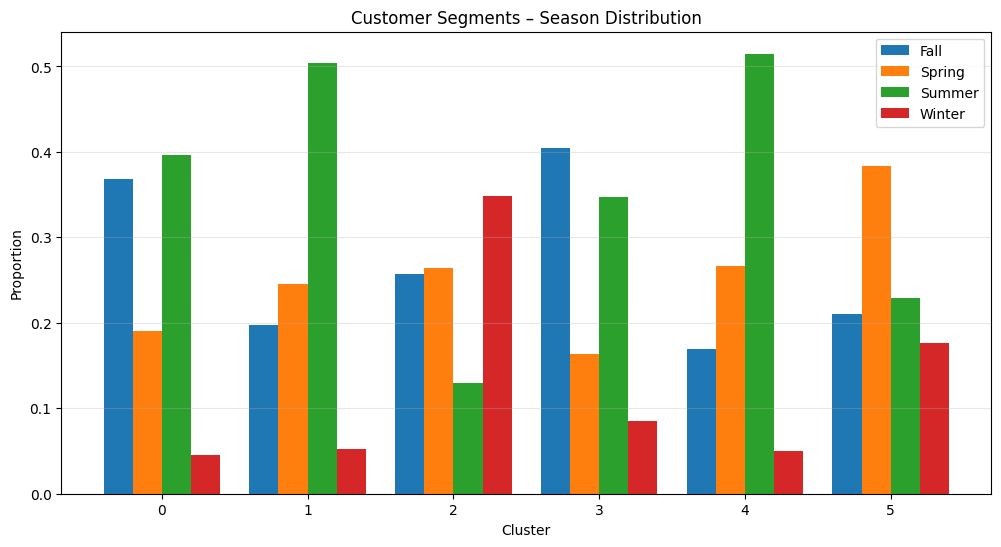

In [ ]:
season_vars = ['season_Fall', 'season_Spring', 'season_Summer', 'season_Winter']
df_season = cluster_summary_original[season_vars].copy()


clusters = df_season.index.astype(str)
x = np.arange(len(clusters))
width = 0.2

plt.figure(figsize=(12, 6))

for i, season in enumerate(season_vars):
  plt.bar(x + i*width, df_season[season], width, label=season)

plt.xticks(x + width*1.5, clusters)
plt.xlabel("Cluster")
plt.ylabel("Proportion")
plt.title("Customer Segments – Season Distribution")
plt.legend()
plt.grid(axis='y', alpha=0.3)



handles, labels = plt.gca().get_legend_handles_labels()
new_labels = ['Fall', 'Spring', 'Summer','Winter']
plt.legend(handles, new_labels,loc='upper right')

plt.show()

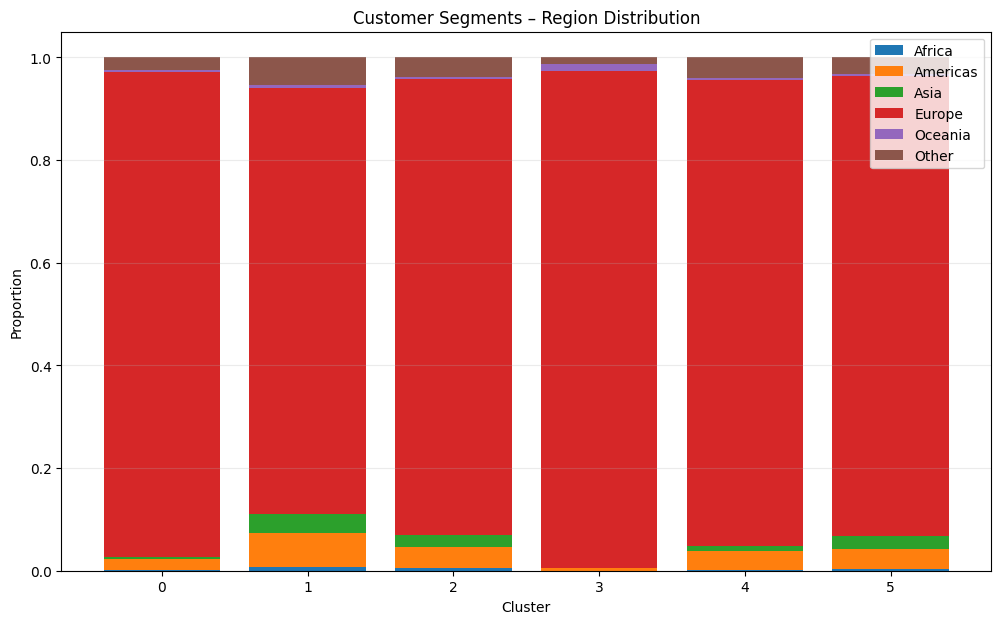

In [ ]:
region_vars = ['region_Africa', 'region_Americas', 'region_Asia','region_Europe', 'region_Oceania', 'region_Other']
df_region = cluster_summary_original[region_vars].copy()
plt.figure(figsize=(12, 7))


bottom = np.zeros(len(df_region))
for region in region_vars:
  plt.bar(df_region.index, df_region[region], bottom=bottom, label=region)
  bottom += df_region[region]

plt.xlabel("Cluster")
plt.ylabel("Proportion")
plt.title("Customer Segments – Region Distribution")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(df_region.index)
plt.grid(axis='y', alpha=0.25)

handles, labels = plt.gca().get_legend_handles_labels()
new_labels = ['Africa', 'Americas', 'Asia', 'Europe', 'Oceania', 'Other']
plt.legend(handles, new_labels,loc='upper right')



plt.show()

<Figure size 1000x1200 with 0 Axes>

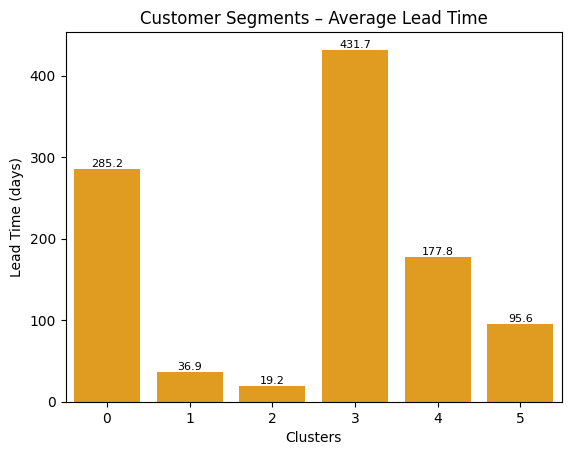

<Figure size 1000x1200 with 0 Axes>

In [ ]:
#lead time differences between each cluster
import seaborn as sns

ax = sns.barplot(cluster_summary_original, x = "Cluster", y ='lead_time', color = "orange" )
plt.xlabel('Clusters')
plt.ylabel('Lead Time (days)')
ax.bar_label(ax.containers[0],fmt="%.1f", fontsize=8)
plt.title("Customer Segments – Average Lead Time")
plt.figure(figsize=(10,12))


#Cluster 3 has highest lead time
#Cluster 2 has lowest lead time


<Figure size 1000x1200 with 0 Axes>

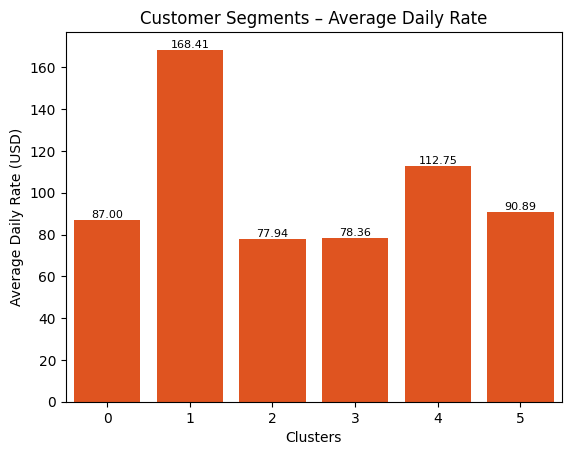

<Figure size 1000x1200 with 0 Axes>

In [ ]:
#average daily rate for each cluster

ax_2 = sns.barplot(data = cluster_summary_original, x = "Cluster", y = "average_daily_rate", color = "orangered")
plt.xlabel("Clusters")
plt.ylabel("Average Daily Rate (USD)")
ax_2.bar_label(ax_2.containers[0],fmt="%.2f", fontsize=8)
plt.title("Customer Segments – Average Daily Rate")
plt.figure(figsize=(10,12))
#Clster 1 spent most per night

<Figure size 1000x1200 with 0 Axes>

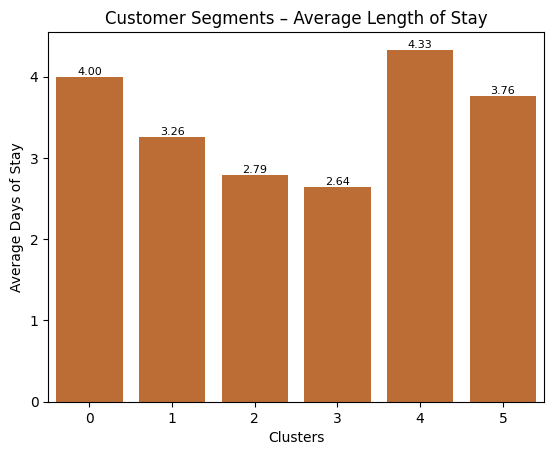

<Figure size 1000x1200 with 0 Axes>

In [ ]:
#length of time stayed
ax_3 = sns.barplot(data = cluster_summary_original, x = "Cluster", y = "length_of_stay", color = "chocolate")
plt.xlabel("Clusters")
plt.ylabel("Average Days of Stay")
ax_3.bar_label(ax_3.containers[0],fmt="%.2f", fontsize=8)
plt.title("Customer Segments – Average Length of Stay")
plt.figure(figsize=(10,12))


[Text(0, 0, '1.98'),
 Text(0, 0, '2.32'),
 Text(0, 0, '1.74'),
 Text(0, 0, '1.91'),
 Text(0, 0, '2.08'),
 Text(0, 0, '1.94')]

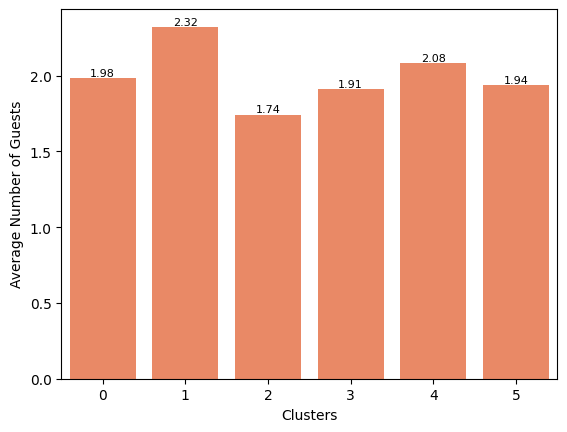

In [ ]:
#average number of guests staying


ax_4 = sns.barplot(data = cluster_summary_original, x = "Cluster", y = "total_guests", color = "coral")
plt.xlabel("Clusters")
plt.ylabel("Average Number of Guests")
ax_4.bar_label(ax_4.containers[0],fmt="%.2f", fontsize=8)
